In [61]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS


from library import print_statistics

In [62]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, .005)
test

'9.16**'

In [63]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [64]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]
data.sample(1)

794


,Unnamed: 0,year,campus,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,...,yearpost,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3
41768,58269,2018,175905101,FROST EL,N,175905,FROST ISD,N,B,Pass,...,0.0,-1.0,0,0,0,0,1,0,0,0


In [65]:
data.doi_year.value_counts()

2018.0    26295
2017.0    17698
2019.0     5812
Name: doi_year, dtype: int64

In [68]:
data['teachers_new'] = pd.to_numeric(data.teachers_new_num, errors='coerce')/pd.to_numeric(data.teachers_num, errors='coerce')
data.teachers_new.sample(5)

37107    0.104914
23197    0.026042
4541     0.143829
44048    0.000000
21650    0.027739
Name: teachers_new, dtype: float64

In [69]:
list(data.columns)

['Unnamed: 0',
 'year',
 'campus',
 'campname',
 'campischarter',
 'district',
 'distname',
 'distischarter',
 'rating_academic',
 'rating_financial',
 'rating_academic_c',
 'type',
 'type_description',
 'cntyname',
 'students_amind_num',
 'students_asian_num',
 'students_black_num',
 'students_cte_num',
 'students_ell_num',
 'students_frpl_num',
 'students_hisp_num',
 'students_num',
 'students_num_d',
 'students_paci_num',
 'students_sped_num',
 'students_tworaces_num',
 'students_white_num',
 'teachers_badegree_num',
 'teachers_exp_ave',
 'teachers_msdegree_num',
 'teachers_new_num',
 'teachers_nodegree_num',
 'teachers_num',
 'teachers_phddegree_num',
 'teachers_tenure_ave',
 'teachers_turnover_ratio_d',
 'alg_avescore',
 'bio_avescore',
 'eng1_avescore',
 'eng2_avescore',
 'm_3rd_avescore',
 'm_4th_avescore',
 'm_5th_avescore',
 'm_6th_avescore',
 'm_7th_avescore',
 'm_8th_avescore',
 'r_3rd_avescore',
 'r_4th_avescore',
 'r_5th_avescore',
 'r_6th_avescore',
 'r_7th_avescore',
 'r

In [70]:
# Inputs 
data[['year', 'campname', 'teachers_num_total']].sample(10)

,year,campname,teachers_num_total
19443,2015,FAIRVIEW ACCELERATED,NaN
46966,2019,LAPOYNOR H S,NaN
47080,2019,TOLAR EL,NaN
5130,2012,S AND S CONS H S,NaN
22251,2015,DUBOSE INT,27.0
42052,2018,HERMAN E UTLEY MIDDLE,50.0
11232,2013,GLENCREST 6TH GRADE SCH,27.0
26138,2016,ANNIE WEBB BLANTON EL,41.0
17611,2014,ANNETTE PERRY EL,25.0
29813,2016,GREEN VALLEY EL,29.0


In [71]:
data['teachers_certified'] = data.teachers_num_certified / data.teachers_num_total
data['teachers_uncertified'] = data.teachers_num_uncertified/ data.teachers_num_total
data['teachers_nodata'] = data.teachers_num_nocertdata/data.teachers_num_total
data['teachers_vocational'] = data.teachers_num_vocational/data.teachers_num_total
data[['year', 'campname', 'treatpost', 'teachers_certified', 'teachers_uncertified', 'teachers_nodata']].sample(10)

,year,campname,treatpost,teachers_certified,teachers_uncertified,teachers_nodata
38967,2018,AUSTIN MIDDLE,True,1.000000,0.0,0.000000
34646,2017,IRION H S,False,1.000000,0.0,0.000000
20673,2015,HOUSTON EL,False,0.666667,0.0,0.333333
14150,2014,PRAIRIE CREEK EL,False,0.529412,0.0,0.470588
46426,2019,SNEED EL,True,NaN,NaN,NaN
44511,2019,BOALS EL,True,NaN,NaN,NaN
48127,2019,SPRINGTOWN RENO EL,True,NaN,NaN,NaN
40000,2018,NAVARRO H S,True,0.960000,0.0,0.040000
32486,2017,BIRDIE ALEXANDER EL,False,1.000000,0.0,0.000000
42208,2018,GUS WINSTON CAIN EL,True,1.000000,0.0,0.000000


In [72]:
#convert year to datetime
df = data.dropna(subset=['teachers_certified'])
df = df.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = df.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost', 'teachers_certified']].sample(5, random_state = 8)

,,district,doi_year,treatpost,teachers_certified
campus,year,,,,
127906001,2015-01-01,127906,2018.0,False,0.958333
19907002,2018-01-01,19907,2017.0,True,0.903846
163904102,2014-01-01,163904,2018.0,False,0.864865
201902109,2014-01-01,201902,2018.0,False,0.830189
71902012,2017-01-01,71902,2017.0,True,0.991803


In [49]:
event_study_model = 'teachers_certified ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + TimeEffects + EntityEffects'

In [51]:
event_study_model = 'teachers_certified ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + TimeEffects + EntityEffects'
mod = PanelOLS.from_formula(event_study_model, df)
res = mod.fit(cov_type='clustered', clusters= df.district)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:     teachers_certified   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):              0.0245
No. Observations:               36128   R-squared (Within):               0.0957
Date:                Thu, Mar 19 2020   R-squared (Overall):              0.0812
Time:                        13:20:43   Log-likelihood                 4.725e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.1342
Entities:                        6336   P-value                           0.0000
Avg Obs:                       5.7020   Distribution:                 F(6,29781)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             0.8184
                            

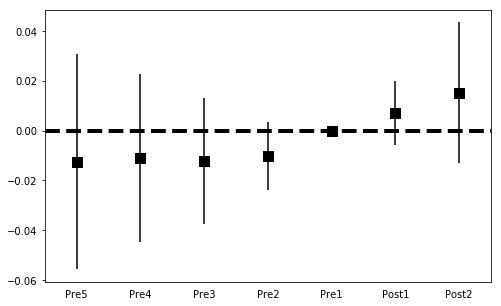

In [53]:
mod = PanelOLS.from_formula(event_study_model, df)
res = mod.fit(cov_type='clustered', clusters= df.district)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'post1', 'post2']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre1':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1, 1, 2]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df['errsig'] = coef_df.err *1.96

fig, ax = plt.subplots(figsize=(8, 5))

coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='errsig', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

fig.savefig(table_path + 'certification_event_study' + '.png', bbox_inches="tight")

In [86]:
event_study_model = 'teachers_tenure_ave ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + TimeEffects + EntityEffects'
mod = PanelOLS.from_formula(event_study_model, df[df.avescores > .5])
res = mod.fit(cov_type='clustered', clusters= df[df.avescores > .5].district)
print(res)

                           PanelOLS Estimation Summary                           
Dep. Variable:     teachers_tenure_ave   R-squared:                        0.0015
Estimator:                    PanelOLS   R-squared (Between):              0.0084
No. Observations:                10019   R-squared (Within):              -0.0585
Date:                 Thu, Mar 19 2020   R-squared (Overall):              0.0007
Time:                         17:06:22   Log-likelihood                -1.287e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.8040
Entities:                         6336   P-value                           0.0941
Avg Obs:                        1.5813   Distribution:                  F(6,7448)
Min Obs:                        0.0000                                           
Max Obs:                        6.0000   F-statistic (robust):             0.6455
                

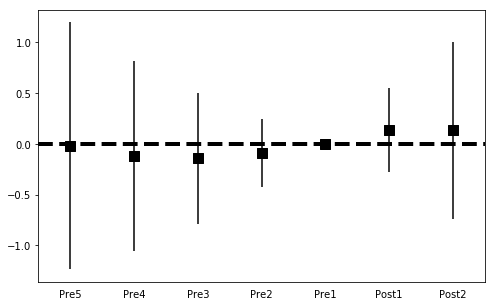

In [88]:
mod = PanelOLS.from_formula(event_study_model, df)
res = mod.fit(cov_type='clustered', clusters= df.district)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'post1', 'post2']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre1':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1, 1, 2]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df['errsig'] = coef_df.err *1.96

fig, ax = plt.subplots(figsize=(8, 5))

coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='errsig', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

fig.savefig(table_path + 'certification_event_study' + '.png', bbox_inches="tight")